In [0]:
from keras.layers import Conv2D, BatchNormalization, Activation, SeparableConv2D, concatenate, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import AveragePooling2D, Input, Flatten, Lambda

from keras import backend as K
from keras.models import Model,Sequential
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import os

Using TensorFlow backend.


In [0]:
# Loading CIFAR Dataset
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))


170500096/170498071 [==============================] - 9s 0us/step


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def space_to_depth_x2(x):
  import tensorflow as tf
  return tf.space_to_depth(x, block_size=2)

In [0]:
inputs = Input(shape=(32, 32, 3,))

# Layer 1
x1 = SeparableConv2D(32,(5,5),border_mode='same', name='Layer1')(inputs)
x1 = BatchNormalization(name = 'bn_conv1')(x1)
x1 = Activation('relu')(x1)

# Layer 2
x2 = Conv2D(32, (5,5), strides=(1,1),border_mode='same', name='Layer_2', use_bias=False)(x1)
X2 = BatchNormalization(name = 'bn_conv2')(x2)
x2 = Activation('relu')(x2)

# Layer 3
x3 = Conv2D(32, (5,5), strides=(1,1), border_mode='same', name='Layer_3', use_bias=False)(x2)
X3 = BatchNormalization(name = 'bn_conv3')(x3)
x3 = Activation('relu')(x3)

#adding skip_connection of layer 3
skip_connection1 = x1
x3_concat =  concatenate([x3, x1])

# Layer 4
x4 = SeparableConv2D(32,(5,5), border_mode='same', name='Layer4')(x3_concat)
x4 = BatchNormalization(name = 'bn_conv4')(x4)
x4 = Activation('relu')(x4)

#adding skip_connection after layer 4
skip_connection2 = x1
x4_concat =  concatenate([x4, skip_connection2])

#max-pooling layer
mp1 = MaxPooling2D(pool_size=(2,2))(x4_concat)

# Layer 5
x5 = SeparableConv2D(32,(3,3), border_mode='same', name='Layer5')(mp1)
x5 = BatchNormalization(name = 'bn_conv5')(x5)
x5 = Activation('relu')(x5)
x5_concat = concatenate([x4,x1])
skip_con5= Lambda(space_to_depth_x2)(x5_concat)
x5_concat = concatenate([skip_con5, x5])

#Layer 6
x6 = Conv2D(32, (5,5), strides=(1,1), border_mode='same', name='Layer_6', use_bias=False)(x5_concat)
X6 = BatchNormalization(name = 'bn_conv6')(x6)
x6 = Activation('relu')(x6)

x6_temp = concatenate([x4,x3])
x6_temp = Lambda(space_to_depth_x2)(x6_temp)
x6_concat = concatenate([x6_temp, x5,x6])

#Layer 7
x7 = SeparableConv2D(32,(3,3), border_mode='same', name='Layer7')(x6_concat)
x7 = BatchNormalization(name = 'bn_conv7')(x7)
x7 = Activation('relu')(x7)
x7_temp = concatenate([x1, x3, x4])
x7_temp = Lambda(space_to_depth_x2)(x7_temp)
x7_concat = concatenate([x5, x6, x7_temp])

#Layer 8
x8 = SeparableConv2D(32,(5,5), border_mode='same', name='Layer8')(x7_concat)
x8 = BatchNormalization(name = 'bn_conv8')(x8)
x8 = Activation('relu')(x8)
x8_temp = concatenate([x1, x4])
x8_temp = Lambda(space_to_depth_x2)(x8_temp)
x8_concat = concatenate([x5, x7, x8_temp])

#Max-Pooling - 2
mp2 = MaxPooling2D(pool_size=(2,2))(x8_concat)
x6_temp = Lambda(space_to_depth_x2)(x6)
mp2_concat = concatenate([mp2, x6_temp])

# Layer 9
x9 = Conv2D(32, (5,5), strides=(1,1), border_mode='same', name='Layer_9', use_bias=False)(mp2_concat)
X9 = BatchNormalization(name = 'bn_conv9')(x9)
x9 = Activation('relu')(x9)
x9_temp = concatenate([x1, x2])
x9_temp = Lambda(space_to_depth_x2)(x9_temp)
x9_temp = concatenate([x9_temp, x7])
x9_temp = Lambda(space_to_depth_x2)(x9_temp)
x9_concat = concatenate([x9, x9_temp])

#Layer 10
x10 = SeparableConv2D(32,(5,5), border_mode='same', name='Layer10')(x9_concat)
x10 = BatchNormalization(name = 'bn_conv10')(x10)
x10 = Activation('relu')(x10)
x10_temp = concatenate([x2, x3])
x10_temp = Lambda(space_to_depth_x2)(x10_temp)
x10_temp = concatenate([x10_temp, x5])
x10_temp = Lambda(space_to_depth_x2)(x10_temp)
x10_temp = concatenate([x10_temp, x9])
x10_concat = concatenate([x10_temp, x10])

#Layer 11
x11 = Conv2D(32, (3,3), strides=(1,1), border_mode='same', name='Layer_11', use_bias=False)(x10_concat)
X11 = BatchNormalization(name = 'bn_conv9')(x11)
x11 = Activation('relu')(x11)
x11_temp = concatenate([x1, x3, x4])
x11_temp = Lambda(space_to_depth_x2)(x11_temp)
x11_temp = concatenate([x11_temp, x5])
x11_temp = Lambda(space_to_depth_x2)(x11_temp)
x11_temp = concatenate([x11_temp, x10])
x11_concat = concatenate([x11_temp, x11])

#Layer 12
x12 = SeparableConv2D(32,(5,5), border_mode='same', name='Layer12')(x11_concat)
x12 = BatchNormalization(name = 'bn_conv12')(x12)
x12 = Activation('relu')(x12)
x12_temp = Lambda(space_to_depth_x2)(x4)
x12_temp = concatenate([x12_temp, x7])
x12_temp = Lambda(space_to_depth_x2)(x12_temp)
x12_temp = concatenate([x12_temp, x10])
x12_concat = concatenate([x12_temp, x12])
layer_last = Conv2D(10, (3,3), strides=(1,1), name='Layer_last', use_bias=False)(x12_concat)

flatten = GlobalAveragePooling2D()(layer_last)
output = Activation('softmax')(flatten)

model = Sequential()
model = Model(inputs = [inputs], output = [output])

W0626 02:14:22.410758 140326759040896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 02:14:22.447019 140326759040896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="Layer1", padding="same")`
  after removing the cwd from sys.path.
W0626 02:14:22.457225 140326759040896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 02:14:22.505868 140326759040896 deprecation_w

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Layer1 (SeparableConv2D)        (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Layer1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
Layer_2 (C

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# model.fit(train_features, train_labels, batch_size=64, epochs=100, verbose=1, validation_data=(test_features,test_labels))
# 

W0626 02:14:26.871975 140326759040896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  
W0626 02:14:27.031625 140326759040896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

Epoch 1/100
390/390 [==============================] - 42s 107ms/step - loss: 1.4862 - acc: 0.4584 - val_loss: 1.3788 - val_acc: 0.4933
Epoch 2/100
390/390 [==============================] - 37s 95ms/step - loss: 1.0666 - acc: 0.6189 - val_loss: 1.1832 - val_acc: 0.5633
Epoch 3/100
390/390 [==============================] - 37s 96ms/step - loss: 0.9070 - acc: 0.6760 - val_loss: 1.7746 - val_acc: 0.4759
Epoch 4/100
390/390 [==============================] - 38s 98ms/step - loss: 0.7912 - acc: 0.7199 - val_loss: 1.2526 - val_acc: 0.5608
Epoch 5/100
390/390 [==============================] - 39s 99ms/step - loss: 0.6959 - acc: 0.7539 - val_loss: 1.3976 - val_acc: 0.5455
Epoch 6/100
390/390 [==============================] - 38s 98ms/step - loss: 0.6153 - acc: 0.7835 - val_loss: 1.0354 - val_acc: 0.6731
Epoch 7/100
390/390 [==============================] - 39s 99ms/step - loss: 0.5541 - acc: 0.8053 - val_loss: 1.4502 - val_acc: 0.5506
Epoch 8/100
390/390 [==============================] -

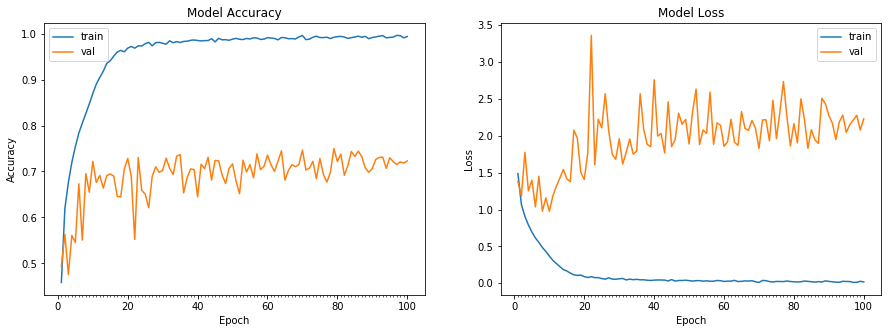

Accuracy on test data is: 72.29


In [10]:

# Importing required packages
import matplotlib.pyplot as plt
import time
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save('CIFAR10_ENAS.hdf5')

In [11]:
score = model.evaluate(test_features, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 290us/step
Test loss: 2.2289949142456056
Test accuracy: 0.7229
